# With Parameter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/train_qso_wo_image.csv')
df_test = pd.read_csv('../data/train_qso_wo_image.csv')

## Scaling

In [3]:
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
s.fit(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])
data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']] = s.transform(data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']])

## Train Test Split

In [4]:
X = data[['ug', 'ur', 'ui', 'uz', 'uj', 'uk', 'uw1', 'uw2', 'gr',
       'gi', 'gz', 'gk', 'gw1', 'gw2', 'ri', 'rz', 'rw1', 'rw2', 'iz', 'ij',
       'ik', 'iw1', 'iw2', 'zj', 'zk', 'zw1', 'zw2', 'jw1', 'jw2', 'kw1',
       'kw2', 'w1w2', 'petroR50_g', 'petroR50_r']]

y = data['class_bin']

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)

## Model(modulos.ai parameters)

n_estimators: 914

criterion: gini

max_features: log2

class_weight: balanced_subsample 

In [6]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    max_depth = 5,
    n_estimators = 914,
    criterion = "gini",
    max_features = "log2",
    class_weight = "balanced_subsample"
    
)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

## Visualization of the model

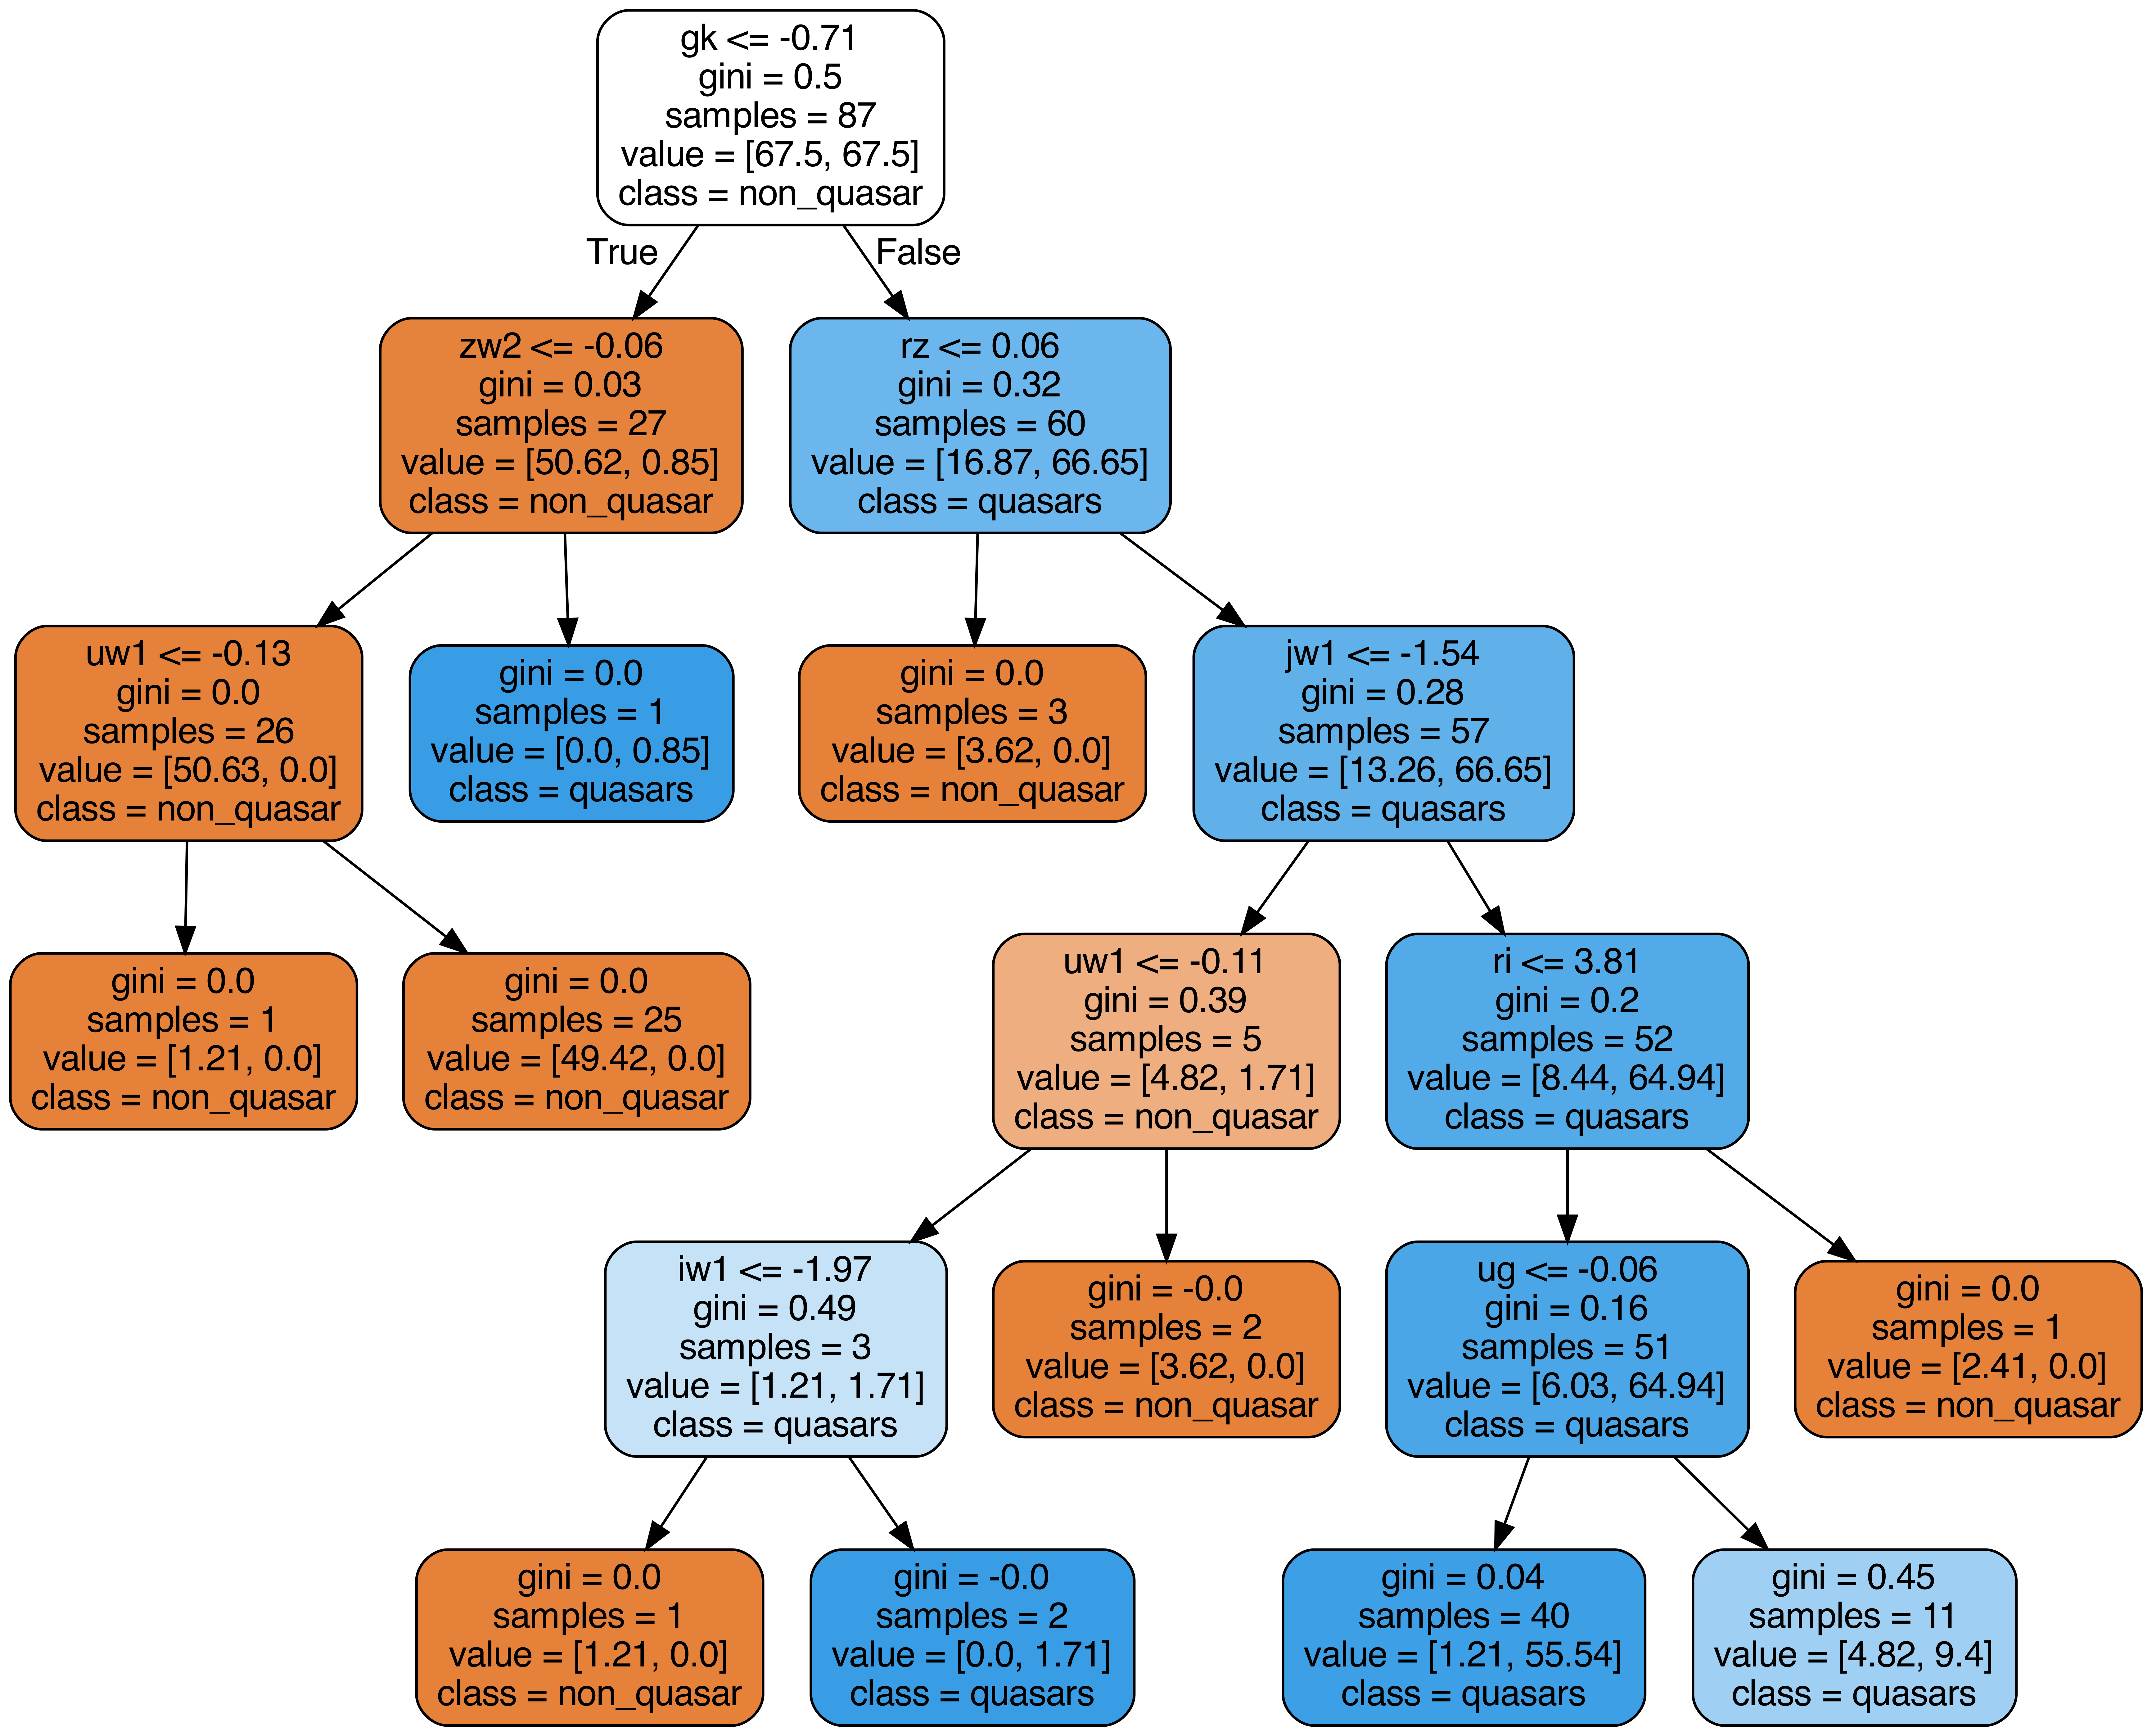

In [33]:
#picking one tree from the clf model
estimator = clf.estimators_[4]

target_names = ['non_quasar','quasars']

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

- value = [67.5,67.5] describes the repartition of these objects between the two class: 67.5 for non quasars and 67.5 for quasars

## Metrics Output

- accuracy: 89.83%
- F1: 93.18%
- ROC_AUC: 95.2%

In [35]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('F1:', metrics.f1_score(y_test,y_pred))

Accuracy: 0.8983050847457628
F1: 0.9318181818181819


In [36]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[12,  4],
       [ 2, 41]])

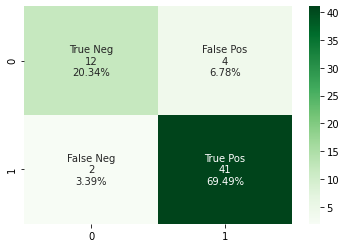

In [11]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

plt.savefig('../figures/rfc_p_cf_matrix')

In [12]:
#generate a no skill prediction
ns_prob = [0 for _ in range(len(y_test))]
#prodict probability
clf_prob = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only/
clf_prob = clf_prob[:, 1]

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_auc = roc_auc_score(y_test, ns_prob)
lr_auc = roc_auc_score(y_test, clf_prob)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.953


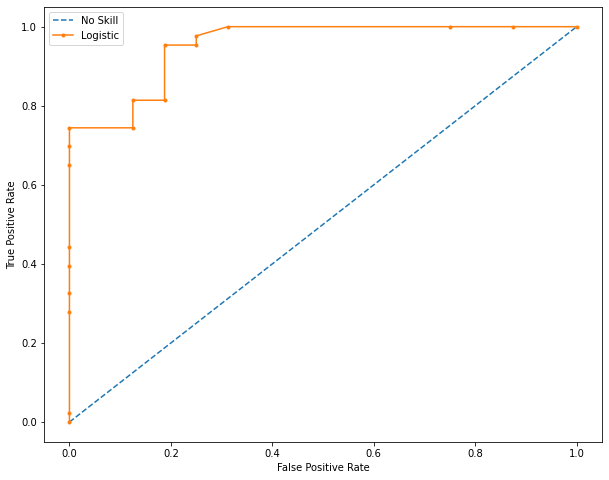

In [14]:
import matplotlib.pyplot as plt
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, clf_prob)


plt.figure(figsize=(10, 8))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('../figures/rfc_v1_rocauc.png')
# show the plot
plt.show()



In [15]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

ij            0.100338
gk            0.068629
gw1           0.067541
rw1           0.057519
ik            0.047343
zj            0.043874
zk            0.038675
gz            0.035693
iw1           0.034996
gw2           0.034427
rz            0.033212
uk            0.030548
rw2           0.028526
uj            0.027868
iw2           0.027181
gi            0.026291
petroR50_r    0.026095
uw1           0.024638
jw2           0.022110
zw1           0.020682
zw2           0.018819
ri            0.018338
gr            0.017926
ug            0.017744
w1w2          0.016037
jw1           0.015445
iz            0.015287
kw2           0.015145
ur            0.014949
uw2           0.013544
uz            0.012704
ui            0.011227
petroR50_g    0.009065
kw1           0.007586
dtype: float64

No handles with labels found to put in legend.


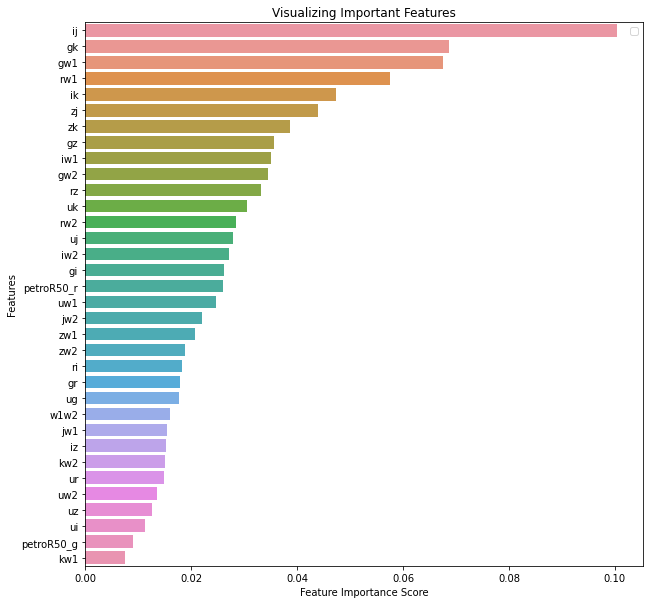

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.savefig('../figures/rfc_v1_features.png')
plt.show()



## Model Valuation: Is there overfitting or underfitting happening to the data?

When the depth of the tree = 6, the model starts to overfitting a bit. But overall, not a really big problem

>1, train: 0.874, test: 0.831
>2, train: 0.926, test: 0.864
>3, train: 0.956, test: 0.881
>4, train: 0.978, test: 0.898
>5, train: 0.978, test: 0.898
>6, train: 1.000, test: 0.898
>7, train: 1.000, test: 0.898
>8, train: 1.000, test: 0.898
>9, train: 1.000, test: 0.898
>10, train: 1.000, test: 0.898
>11, train: 1.000, test: 0.898
>12, train: 1.000, test: 0.898
>13, train: 1.000, test: 0.898
>14, train: 1.000, test: 0.898
>15, train: 1.000, test: 0.898
>16, train: 1.000, test: 0.898
>17, train: 1.000, test: 0.898
>18, train: 1.000, test: 0.898
>19, train: 1.000, test: 0.898


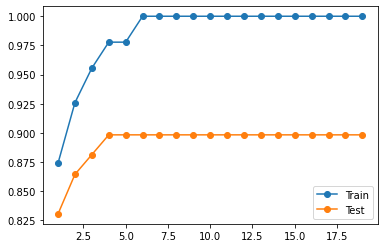

In [33]:
train_scores, test_scores = list(), list()

# define the tree depths to evaluate
values = [i for i in range(1, 20)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(
    max_depth=i,
    n_estimators = 914,
    criterion = "gini",
    max_features = "log2",
    class_weight = "balanced_subsample")
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = metrics.accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = metrics.accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

# Discussion

In [41]:
df = pd.read_csv('../data/train_qso.csv')

<AxesSubplot:xlabel='ij', ylabel='Count'>

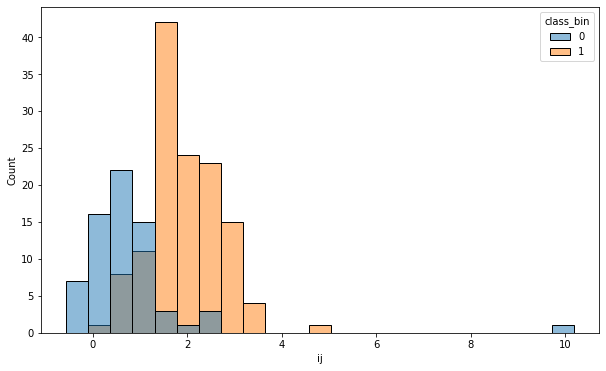

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="ij", hue="class_bin")

<AxesSubplot:xlabel='gk', ylabel='Count'>

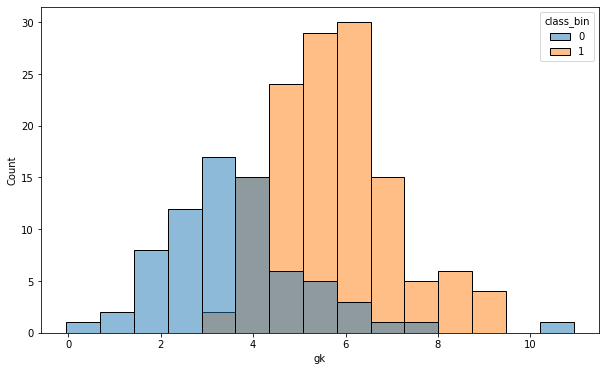

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gk", hue="class_bin")

<AxesSubplot:xlabel='gw1', ylabel='Count'>

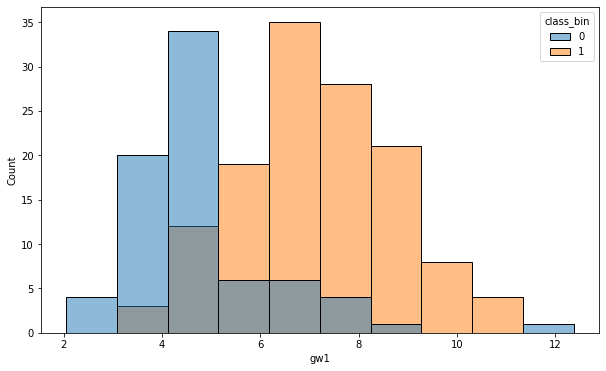

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data = df,x="gw1", hue="class_bin")